<a href="https://colab.research.google.com/github/Astro-Beam/ASTRO/blob/main/Neural%20Networks/Denoising_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Necessary dependencies / libraries

In [ ]:
#Run this block to import the necessary dependencies
!pip install torch torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.optimize import curve_fit
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

#Denoising Autoencoder (DAE)

##Create the training dataset

###Comments

Explaining the comments and the choices made in the code:
- `# Convert to PyTorch tensors` - A torch.tensor is a multi-dimensional matrix containing elements of a single data type. We convert the data into a PyTorch tensor in order to feed this data into PyTorch models, such as our autoencoder, and use it for forward passes, training, and evaluation.
- `torch.float32` - It means that each element in the tensor will be stored as a 32-bit floating point number (a common data type for numeric operations in neural networks).
It ensures that the data is in a format suitable for floating-point computations, which is critical for training neural networks in PyTorch since most deep learning operations work with floating point numbers.
- `# Batch size` - Batch size is a hyperparameter that defines the number of samples for the autoencoder to work through before updating internal model parameters

###Code

In [ ]:
# Define a function to generate a background-only signal (without spectral line)
def generate_background_signal(n_samples):
    freq_range = np.linspace(1418, 1422, n_samples)
    # Random background signal generation
    signal = (np.sin(2 * np.pi * np.random.uniform(0.05, 0.5) * freq_range) +
              np.random.uniform(0.05, 0.5) * np.sin(2 * np.pi * np.random.uniform(0.05, 0.5) * freq_range))
    # Add random Gaussian noise
    signal += np.random.normal(0, np.random.uniform(0.1, 0.3), len(signal))
    # Normalize the signal
    signal += np.abs(np.min(signal))
    signal /= np.max(np.abs(signal))
    return signal

# Define a function to generate a signal with a spectral line
def generate_signal_with_spectral_line(n_samples):
    freq_range = np.linspace(1418, 1422, n_samples)
    # Add randomness to the background signal generation
    signal = (np.sin(2 * np.pi * np.random.uniform(0.05, 0.5) * freq_range) +
              np.random.uniform(0.05, 0.5) * np.sin(2 * np.pi * np.random.uniform(0.05, 0.5) * freq_range))
    # Add the spectral line at a random frequency
    signal += np.random.uniform(0.7, 1.2) * np.exp(-0.5 * ((freq_range - np.random.uniform(1419.9, 1420.1)) / 0.1)**2)
    # Add random Gaussian noise
    signal += np.random.normal(0, np.random.uniform(0.1, 0.3), len(signal))
    # Normalize the signal
    signal += np.abs(np.min(signal))
    signal /= np.max(np.abs(signal))
    return signal

# Signal parameters
n_samples = 1000  # Number of sample points in each signal
freq_range = np.linspace(1418, 1422, n_samples)  # Frequency range
n_signals = 3000  # Total number of signals to generate
signals_fraction = n_signals // 2 # Number of signals WITHOUT spectral lines

# Generate half signals with spectral lines and half without
signals = []
labels = []

# Generate background-only signals
for _ in range(signals_fraction):
    signals.append(generate_background_signal(n_samples))
    labels.append(0)  # Label for background-only

# Generate signals with spectral lines
for _ in range(n_signals - signals_fraction):
    signals.append(generate_signal_with_spectral_line(n_samples))
    labels.append(1)  # Label for signal with spectral line

# Convert to PyTorch tensors
signals_tensor = torch.tensor(signals, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Create a DataLoader for batching
dataset = TensorDataset(signals_tensor, labels_tensor)
batch_size = 64  # Batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

##Define the DAE

###Comments

Comments:
- `nn.Module` is the base class for all neural networks in PyTorch.
- `ReLU (nn.ReLU())` - This is a popular activation function that introduces non-linearity into the model (Activation functions are essential in neural networks as they determine the output of a node given an input or set of inputs). It helps to handle complex data distributions and makes the model more powerful. The **Rectified Linear Unit** (ReLU) is one of the most widely used activation functions in deep learning. The ReLU function is defined as: **ReLU(x) = max(0, x)**. This means that if the input x is positive, the output will be x. If the input x is negative, the output will be 0.
- `nn.Linear(n_samples, 512)` - The first layer takes in the input (which has n_samples data points) and reduces it to 512 neurons.
- `nn.Linear(512, 128)` - This second layer further compresses the 512 neurons down to 128 neurons.
- `nn.Linear(128, 32)` - The final layer compresses the 128 neurons down to 32 neurons, which is the **latent space representation**. This is where the most significant compression occurs.
- `nn.Tanh()` -  [DEPRECATED]  We use the **tanh** activation function, so that our values are between -1 and 1.

- `nn.Sigmoid()` - The **sigmoid activation function** outputs values between 0 and 1. It introduces non-linearity and is particularly useful for making sure the output remains within a specific range.

###Code

In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(n_samples, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        # Decoder with Tanh for negative values
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, n_samples),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the DAE model
dae = DenoisingAutoencoder()

# Print the model architecture
print(dae)

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1000, bias=True)
    (5): Sigmoid()
  )
)


##Define the training loop

###Comments

We then have to define the **loss function** and the **optimizer** we will use in our autoencoder, in order to create the training loop.
 - For the **loss function** we use the **Mean Squared Error** function, a popular loss function used in regression tasks that measures the average squared differences between predicted and actual values.
 - For the **optimizer** we use the **ADAM optimizer**. Adaptive Moment Estimation is an algorithm for optimization technique for gradient descent. The method is really efficient when working with large problem involving a lot of data or parameters. It requires less memory and is efficient. Intuitively, it is a combination of the ‘gradient descent with momentum’ algorithm and the ‘RMSP’ algorithm.

We have to consider the **number of epochs** for the best training of the autoencoder. Generally speaking, the number of epochs will change if the dataset is bigger.
 - The number of epochs should not be decided a-priori. We should run the training and monitor the training and validation losses over time and stop training when the validation loss reaches a plateau or starts increasing. This technique is called "**early stopping**" and is a good practice in machine learning.


###Code

Epoch [1/50], Loss: 0.0136
Epoch [2/50], Loss: 0.0094
Epoch [3/50], Loss: 0.0083
Epoch [4/50], Loss: 0.0070
Epoch [5/50], Loss: 0.0067
Epoch [6/50], Loss: 0.0072
Epoch [7/50], Loss: 0.0071
Epoch [8/50], Loss: 0.0067
Epoch [9/50], Loss: 0.0065
Epoch [10/50], Loss: 0.0065
Epoch [11/50], Loss: 0.0058
Epoch [12/50], Loss: 0.0056
Epoch [13/50], Loss: 0.0062
Epoch [14/50], Loss: 0.0053
Epoch [15/50], Loss: 0.0057
Epoch [16/50], Loss: 0.0060
Epoch [17/50], Loss: 0.0058
Epoch [18/50], Loss: 0.0053
Epoch [19/50], Loss: 0.0051
Epoch [20/50], Loss: 0.0056
Epoch [21/50], Loss: 0.0057
Epoch [22/50], Loss: 0.0050
Epoch [23/50], Loss: 0.0053
Epoch [24/50], Loss: 0.0045
Epoch [25/50], Loss: 0.0055
Epoch [26/50], Loss: 0.0049
Epoch [27/50], Loss: 0.0052
Epoch [28/50], Loss: 0.0051
Epoch [29/50], Loss: 0.0052
Epoch [30/50], Loss: 0.0044
Epoch [31/50], Loss: 0.0049
Epoch [32/50], Loss: 0.0049
Epoch [33/50], Loss: 0.0051
Epoch [34/50], Loss: 0.0050
Epoch [35/50], Loss: 0.0043
Epoch [36/50], Loss: 0.0041
E

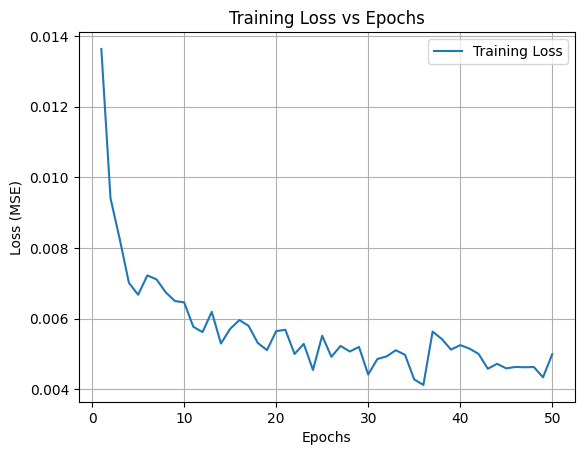

In [ ]:
# Loss function (Mean Squared Error) and optimizer (Adam)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(dae.parameters(), lr=0.001)

# Noise generation for corrupting the input
def add_noise(signal, noise_level=0.1):
    noise = torch.normal(0, noise_level, signal.shape)
    noisy_signal = signal + noise
    return noisy_signal

# Number of epochs
n_epochs = 50

# List to store the loss values for each epoch
loss_values = []

for epoch in range(n_epochs):
    for data in dataloader:
        clean_signals = data[0]  # Get the clean signals batch

        # Corrupt the clean signals with noise
        noisy_signals = add_noise(clean_signals)

        # Forward pass: autoencoder's prediction from noisy signals
        reconstructed_signals = dae(noisy_signals)

        # Compute the loss (reconstruction error) between the original clean signal and the reconstructed signal
        loss = criterion(reconstructed_signals, clean_signals)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Store the loss for each epoch
    loss_values.append(loss.item())

    # Print loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

# Plot the loss versus epochs
plt.plot(range(1, n_epochs + 1), loss_values, label='Training Loss')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.legend()
plt.show()

##Autoencoder testing and results visualization

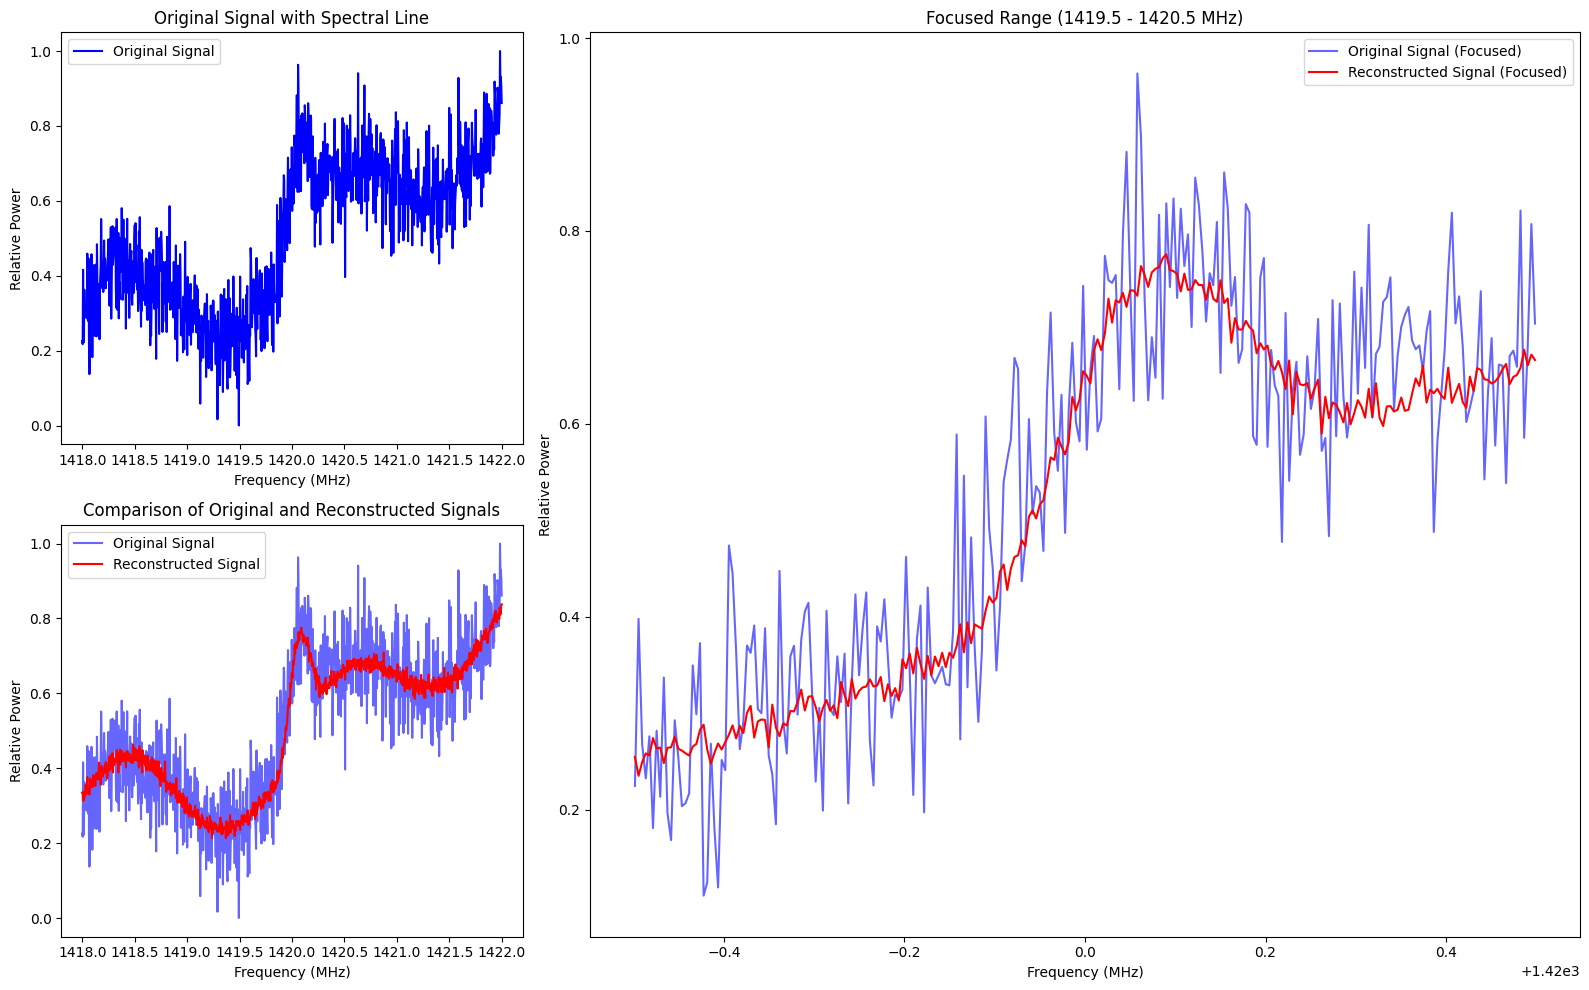

In [ ]:
# Test the autoencoder with a sample signal
sample_signal = generate_signal_with_spectral_line(n_samples)
sample_signal_tensor = torch.tensor(sample_signal, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Pass the signal through the autoencoder
with torch.no_grad():
    reconstructed_signal = dae(sample_signal_tensor).squeeze(0).numpy()

# Define the focus range for a specific frequency range
focus_range_mask = (freq_range >= 1419.5) & (freq_range <= 1420.5)
focused_freq_range = freq_range[focus_range_mask]
focused_clean_signal = sample_signal[focus_range_mask]
focused_reconstructed_signal = reconstructed_signal[focus_range_mask]

# Create the subplots in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

# Upper left plot: Original Signal with Spectral Line
axs[0, 0].plot(freq_range, sample_signal, label='Original Signal', color='blue')
axs[0, 0].set_title('Original Signal with Spectral Line')
axs[0, 0].set_xlabel('Frequency (MHz)')
axs[0, 0].set_ylabel('Relative Power')
axs[0, 0].legend()

# Lower left plot: Comparison of Noisy and Reconstructed Signal
axs[1, 0].plot(freq_range, sample_signal, label='Original Signal', color='blue', alpha=0.6)  # Plot the original signal
axs[1, 0].plot(freq_range, reconstructed_signal, label='Reconstructed Signal', color='red')
axs[1, 0].set_title('Comparison of Original and Reconstructed Signals')
axs[1, 0].set_xlabel('Frequency (MHz)')
axs[1, 0].set_ylabel('Relative Power')
axs[1, 0].legend()

# Focused plot in the middle and right of the grid (spanning both rows)
ax_focus = plt.subplot2grid((2, 3), (0, 1), colspan=2, rowspan=2)
ax_focus.plot(focused_freq_range, focused_clean_signal, label='Original Signal (Focused)', color='blue', alpha=0.6)
ax_focus.plot(focused_freq_range, focused_reconstructed_signal, label='Reconstructed Signal (Focused)', color='red')
ax_focus.set_title('Focused Range (1419.5 - 1420.5 MHz)')
ax_focus.set_xlabel('Frequency (MHz)')
ax_focus.set_ylabel('Relative Power')
ax_focus.legend()

# Hide unused subplot space
axs[0, 1].axis('off')
axs[0, 2].axis('off')
axs[1, 1].axis('off')
axs[1, 2].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

#Convolutional Neural Network Classifier (CNNC)

## Define the CNN

In [ ]:
# Define the classifier network
class SpectralLineClassifier(nn.Module):
    def __init__(self, input_size):
        super(SpectralLineClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)  # Output layer with 2 classes (with or without spectral line)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation on the final layer
        return x

## Define the training loop

In [ ]:
# Initialize classifier
input_size = n_samples  # Size of each signal
classifier = SpectralLineClassifier(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# Example training loop (after training the autoencoder)
epochs = 50
for epoch in range(epochs):
    for signals, labels in dataloader:
        # Reconstruct signals with the autoencoder
        with torch.no_grad():
            reconstructed_signals = dae(signals)

        # Feed reconstructed signals into classifier
        outputs = classifier(reconstructed_signals)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/50], Loss: 0.5562
Epoch [2/50], Loss: 0.0413
Epoch [3/50], Loss: 0.0128
Epoch [4/50], Loss: 0.0071
Epoch [5/50], Loss: 0.0060
Epoch [6/50], Loss: 0.0098
Epoch [7/50], Loss: 0.0058
Epoch [8/50], Loss: 0.0023
Epoch [9/50], Loss: 0.0016
Epoch [10/50], Loss: 0.0011
Epoch [11/50], Loss: 0.0033
Epoch [12/50], Loss: 0.0054
Epoch [13/50], Loss: 0.0009
Epoch [14/50], Loss: 0.0313
Epoch [15/50], Loss: 0.0001
Epoch [16/50], Loss: 0.0014
Epoch [17/50], Loss: 0.0004
Epoch [18/50], Loss: 0.0002
Epoch [19/50], Loss: 0.0011
Epoch [20/50], Loss: 0.0007
Epoch [21/50], Loss: 0.0002
Epoch [22/50], Loss: 0.0001
Epoch [23/50], Loss: 1.5562
Epoch [24/50], Loss: 0.0043
Epoch [25/50], Loss: 0.0012
Epoch [26/50], Loss: 0.0004
Epoch [27/50], Loss: 0.0006
Epoch [28/50], Loss: 0.0004
Epoch [29/50], Loss: 0.0008
Epoch [30/50], Loss: 0.0002
Epoch [31/50], Loss: 0.0009
Epoch [32/50], Loss: 0.0002
Epoch [33/50], Loss: 0.0025
Epoch [34/50], Loss: 0.0001
Epoch [35/50], Loss: 0.0004
Epoch [36/50], Loss: 0.0010
E

## Test the whole pipeline

`test_signal_classification` : Tests the classification of a single signal.
Args: **signal**: The input signal (1D numpy array). **label**: The true label (0 for no spectral line, 1 for spectral line). Returns: predicted_label: The predicted label by the classifier.

Testing Signal with Spectral Line:
True Label: Spectral Line
Predicted Label: Spectral Line


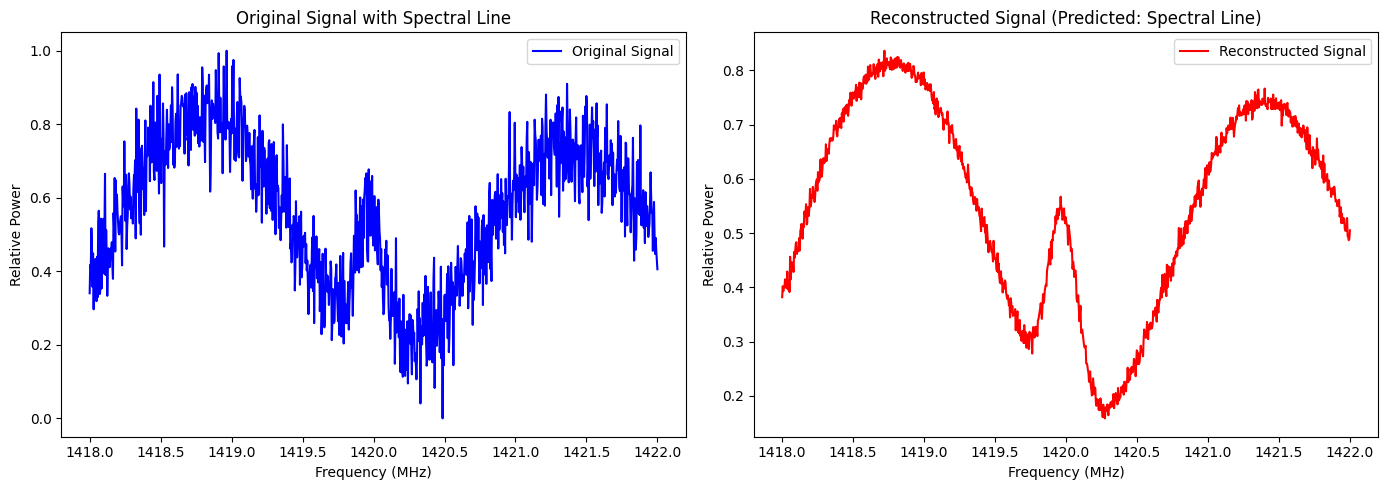


Testing Background-Only Signal:
True Label: No Spectral Line
Predicted Label: No Spectral Line


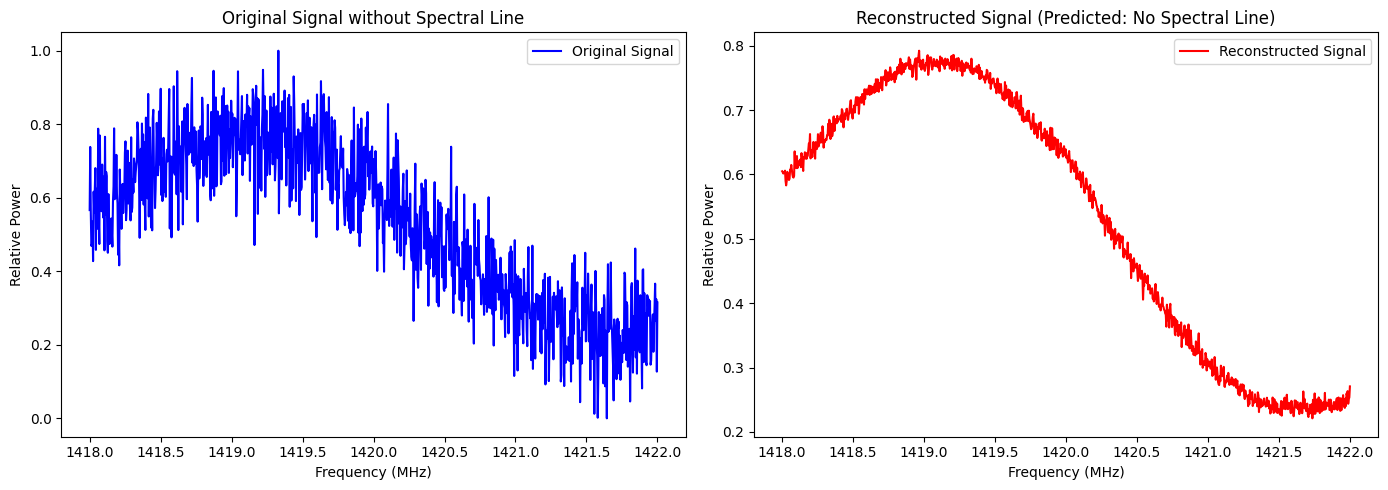

0

In [ ]:
# Define a test function that also plots the signals
def test_and_plot_signal_classification(signal, label):
    # Convert the signal to a PyTorch tensor and add batch dimension
    signal_tensor = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)

    # Pass the signal through the autoencoder to get the reconstructed signal
    with torch.no_grad():
        reconstructed_signal = dae(signal_tensor).squeeze(0).numpy()

    # Pass the reconstructed signal through the classifier to get the output
    output = classifier(torch.tensor(reconstructed_signal, dtype=torch.float32).unsqueeze(0))
    predicted_label = torch.argmax(nn.functional.softmax(output, dim=1), dim=1).item()

    # Plot the original and reconstructed signals
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot original signal
    axs[0].plot(freq_range, signal, label='Original Signal', color='blue')
    axs[0].set_title(f'Original Signal {"with" if label == 1 else "without"} Spectral Line')
    axs[0].set_xlabel('Frequency (MHz)')
    axs[0].set_ylabel('Relative Power')
    axs[0].legend()

    # Plot reconstructed signal
    axs[1].plot(freq_range, reconstructed_signal, label='Reconstructed Signal', color='red')
    axs[1].set_title(f'Reconstructed Signal (Predicted: {"Spectral Line" if predicted_label == 1 else "No Spectral Line"})')
    axs[1].set_xlabel('Frequency (MHz)')
    axs[1].set_ylabel('Relative Power')
    axs[1].legend()

    # Print results
    print("True Label:", "Spectral Line" if label == 1 else "No Spectral Line")
    print("Predicted Label:", "Spectral Line" if predicted_label == 1 else "No Spectral Line")

    plt.tight_layout()
    plt.show()

    return predicted_label

# Example usage of the test function
# Generate a test signal (with or without spectral line) and label
test_signal_with_line = generate_signal_with_spectral_line(n_samples)  # Generates a signal with spectral line
test_signal_without_line = generate_background_signal(n_samples)       # Generates a background-only signal

# Test the signal with a spectral line and plot results
print("Testing Signal with Spectral Line:")
test_and_plot_signal_classification(test_signal_with_line, label=1)

# Test the signal without a spectral line and plot results
print("\nTesting Background-Only Signal:")
test_and_plot_signal_classification(test_signal_without_line, label=0)

#Spectral Line Detection Autoencoder (SLDAE)

##Create the training dataset

We create a dataset, generated using the following function: <br>
`generate_signal_and_spectral_line` : Returns a clean (non-noisy) random signal (generated using a sin and a cos function) that contains a spectral line, along with the spectral line found in that signal. The spectral line has a random amplitude, and is found at a random position within a range. <br> We use this structure, so that the dataset is comprised of both signals and their respective spectral lines, used for the training of the autoencoder, so that it reconstructs the spectral line found in a signal, given only the spectral-line-containing signal.

## Define the SLDAE

## Define the training loop

## Test the entire pipeline

The whole pipeline has the following structure: <br>

*signal* -> **DAE** -> **CNN** -> **SLDAE** -> *spectral line*

